# Chapter 4: The Bias-Variance Trade-off

Exercise 17: Generating and Modeling Synthetic Classification Data

In [5]:
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [3]:
X_synthetic, y_synthetic = make_classification (n_samples=1000, n_features=200, n_informative=3, n_redundant=10, n_repeated=0, n_classes=2,n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=0.8,hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=24)

In [4]:
print(X_synthetic.shape, y_synthetic.shape)

(1000, 200) (1000,)


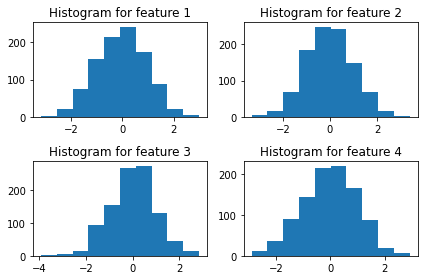

In [5]:
for plot_index in range(4):
    plt.subplot(2,2,plot_index+1)
    plt.hist(X_synthetic[:,plot_index])
    plt.title('Histogram for feature {}'.format(plot_index+1))
plt.tight_layout()

In [6]:
X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_synthetic, y_synthetic, test_size=0.2, random_state=24)
lr_syn = LogisticRegression(solver='liblinear', penalty='l1', C=1000, random_state=1) 
lr_syn.fit(X_syn_train, y_syn_train)

LogisticRegression(C=1000, penalty='l1', random_state=1, solver='liblinear')

In [7]:
lr_syn.fit(X_syn_train, y_syn_train)

LogisticRegression(C=1000, penalty='l1', random_state=1, solver='liblinear')

In [8]:
y_syn_train_predict_proba = lr_syn.predict_proba(X_syn_train)
roc_auc_score(y_syn_train, y_syn_train_predict_proba[:,1])

0.9420000000000001

In [9]:
y_syn_test_predict_proba = lr_syn.predict_proba(X_syn_test)
roc_auc_score(y_syn_test, y_syn_test_predict_proba[:,1])

0.8075807580758075

The difference between the scores of the testing and training data is due to the high "C" parameter (inverse of regularization strength), because the higher this value, the lower the regularization, and low regularization means its more likely to have overfitting when we train the model (high score for training data and low score to test data).

Exercise 18: Reducing Overfitting on the Synthetic Data Classification Problem

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve

In [24]:
n_folds = 4
k_folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)
print(k_folds.n_splits)

4


In [20]:
C_val_exponents = np.linspace(3,-3,13)
C_vals = np.float(10)**C_val_exponents
C_vals

array([1.00000000e+03, 3.16227766e+02, 1.00000000e+02, 3.16227766e+01,
       1.00000000e+01, 3.16227766e+00, 1.00000000e+00, 3.16227766e-01,
       1.00000000e-01, 3.16227766e-02, 1.00000000e-02, 3.16227766e-03,
       1.00000000e-03])

In [21]:
def cross_val_C_search(k_folds, C_vals, model, X, Y):
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))

    cv_test_roc = [[]]*len(C_vals)

    for c_val_counter in range(len(C_vals)):
        #Set the C value for the model object
        model.C = C_vals[c_val_counter]
        #Count folds for each value of C
        fold_counter = 0

        for train_index, test_index in k_folds.split(X, Y):
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]

            model.fit(X_cv_train, y_cv_train)

            y_cv_train_predict_proba = model.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])

            y_cv_test_predict_proba = model.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])

            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)

            fold_counter += 1

        print('Done with C = {}'.format(lr_syn.C))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [27]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search(k_folds, C_vals, lr_syn, X_syn_train, y_syn_train)

Done with C = 1000.0
Done with C = 316.22776601683796
Done with C = 100.0
Done with C = 31.622776601683793
Done with C = 10.0
Done with C = 3.1622776601683795
Done with C = 1.0
Done with C = 0.31622776601683794
Done with C = 0.1
Done with C = 0.03162277660168379
Done with C = 0.01
Done with C = 0.0031622776601683794
Done with C = 0.001


Text(0.5, 1.0, 'Cross validation scores for each fold')

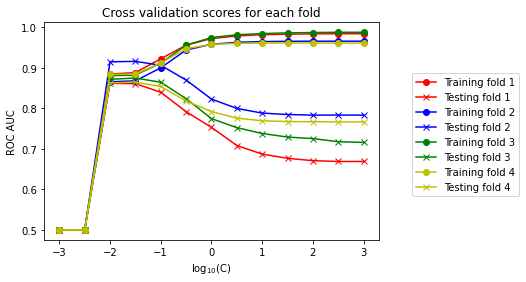

In [31]:
cmap = ['r', 'b', 'g', 'y']
for this_fold in range(n_folds):
    plt.plot(C_val_exponents, cv_train_roc_auc[this_fold], '-o', color = cmap[this_fold], label='Training fold {}'.format(this_fold+1))
    plt.plot(C_val_exponents, cv_test_roc_auc[this_fold], '-x', color = cmap[this_fold], label='Testing fold {}'.format(this_fold+1))
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend(loc = [1.1, 0.2])
plt.title('Cross validation scores for each fold')

Text(0.5, 1.0, 'Cross validation scores averaged over all folds')

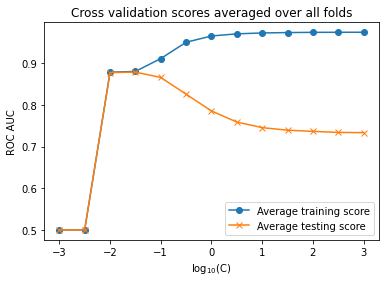

In [32]:
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation scores averaged over all folds')

In [34]:
best_C_val_bool = C_val_exponents == -1.5
best_C_val_bool.astype(int)
best_C_val_ix = np.nonzero(best_C_val_bool.astype(int)) 
best_C_val_ix[0][0]

9

Text(0, 0.5, 'True positive rate')

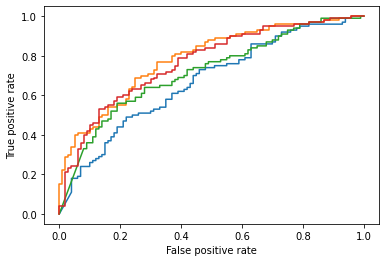

In [36]:
for this_fold in range(n_folds):
    fpr = cv_test_roc[best_C_val_ix[0][0]][this_fold][0]
    tpr = cv_test_roc[best_C_val_ix[0][0]][this_fold][1]
    plt.plot(fpr, tpr, label='Fold {}'.format(this_fold+1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [37]:
lr_syn.C = 10**(-1.5)
lr_syn.fit(X_syn_train, y_syn_train)

LogisticRegression(C=0.03162277660168379, penalty='l1', random_state=1,
                   solver='liblinear')

In [38]:
y_syn_train_predict_proba = lr_syn.predict_proba(X_syn_train)
roc_auc_score(y_syn_train, y_syn_train_predict_proba[:,1])

0.8802812499999999

In [39]:
y_syn_test_predict_proba = lr_syn.predict_proba(X_syn_test)
roc_auc_score(y_syn_test, y_syn_test_predict_proba[:,1])

0.8847884788478848

In [40]:
sum((lr_syn.coef_ != 0)[0])

2

In [41]:
lr_syn.intercept_

array([0.])

# Activity 4: Cross-Validation and Feature Engineering with the Case Study Data

In [6]:
data = pd.read_csv('chapter1_cleaned_data.csv', index_col='ID')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26664 entries, 798fc410-45c1 to 15d69f9f-5ad3
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   LIMIT_BAL                   26664 non-null  int64 
 1   SEX                         26664 non-null  int64 
 2   EDUCATION                   26664 non-null  int64 
 3   MARRIAGE                    26664 non-null  int64 
 4   AGE                         26664 non-null  int64 
 5   PAY_1                       26664 non-null  int64 
 6   PAY_2                       26664 non-null  int64 
 7   PAY_3                       26664 non-null  int64 
 8   PAY_4                       26664 non-null  int64 
 9   PAY_5                       26664 non-null  int64 
 10  PAY_6                       26664 non-null  int64 
 11  BILL_AMT1                   26664 non-null  int64 
 12  BILL_AMT2                   26664 non-null  int64 
 13  BILL_AMT3                   266

In [8]:
features = data.columns.tolist()
remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'EDUCATION_CAT', 'graduate school', 'high school', 'none', 'others', 'university', 'default payment next month']
features = [item for item in features if item not in remove]
response = ['default payment next month']

In [9]:
X = data[features].values
y = data[response].values

In [10]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=24)

In [11]:
from sklearn.preprocessing import MinMaxScaler
min_max_sc = MinMaxScaler()

In [12]:
log_reg = sk.linear_model.LogisticRegression(solver = 'saga', penalty = 'l1', max_iter = 1000)

In [13]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', min_max_sc), ('model', log_reg)])

In [14]:
pipe.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('model', LogisticRegression(max_iter=1000, penalty='l1', solver='saga'))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'model': LogisticRegression(max_iter=1000, penalty='l1', solver='saga'),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 1000,
 'model__multi_class': 'auto',
 'model__n_jobs': None,
 'model__penalty': 'l1',
 'model__random_state': None,
 'model__solver': 'saga',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

In [15]:
c_range = [10**2, 10, 1, 10**-1, 10**-2, 10**-3]
c_expo = [2, 1, 0, -1, -2, -3]
c_range

[100, 10, 1, 0.1, 0.01, 0.001]

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
n_folds = 4
k_folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)
print(k_folds.n_splits)

4


In [22]:
def cross_val_C_search_pipe(k_folds, C_vals, pipeline, X, Y):
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))

    cv_test_roc = [[]]*len(C_vals)

    for c_index in range(len(C_vals)):
        #Set the C value for the model object
        pipeline.set_params(model__C = C_vals[c_index]) 
        #Count folds for each value of C
        fold_counter = 0

        for train_index, test_index in k_folds.split(X, Y):
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]

            pipeline.fit(X_cv_train, y_cv_train.ravel())

            y_cv_train_predict_proba = pipeline.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_index] = roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])

            y_cv_test_predict_proba = pipeline.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_index] = roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])

            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_index].append(this_fold_roc)

            fold_counter += 1

        print('Done with C = {}'.format(pipeline.get_params()['model__C']))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [24]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(k_folds, c_range, pipe, X_train, y_train)

Done with C = 100
Done with C = 10
Done with C = 1
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


Text(0.5, 1.0, 'Cross validation scores averaged over all folds')

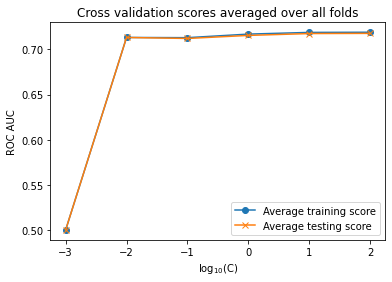

In [100]:
plt.plot(c_expo, np.mean(cv_train_roc_auc, axis=0), '-o',label='Average training score')
plt.plot(c_expo, np.mean(cv_test_roc_auc, axis=0), '-x',label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation scores averaged over all folds')

In [2]:
from sklearn.preprocessing import PolynomialFeatures
make_interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
make_interactions

PolynomialFeatures(include_bias=False, interaction_only=True)

In [25]:
X_with_interactions = make_interactions.fit_transform(X)
X_train_int, X_test_int, y_train_int, y_test_int = sk.model_selection.train_test_split(X_with_interactions, y, test_size=0.2, random_state=24)

In [26]:
cv_train_roc_auc_int, cv_test_roc_auc_int, cv_test_roc_int = cross_val_C_search_pipe(k_folds, c_range, pipe, X_train_int, y_train_int)

C:\Users\Vinicius\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Vinicius\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Vinicius\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Vinicius\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Done with C = 100
C:

Text(0.5, 1.0, 'Cross validation scores averaged over all folds')

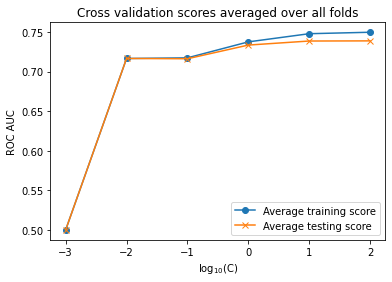

In [27]:
plt.plot(c_expo, np.mean(cv_train_roc_auc_int, axis=0), '-o',label='Average training score')
plt.plot(c_expo, np.mean(cv_test_roc_auc_int, axis=0), '-x',label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation scores averaged over all folds')